In [159]:
from ipynb.fs.defs.ELO_Tracking import get_pre_elo
from ipynb.fs.defs.Modeling_Prep_2 import get_player_games_before, get_player_avgs_over_last_x_games, get_team_avgs_over_last_x_games, get_out_players_for_game, create_team_predictions, pregame_stat_2, create_predictdf_2
from ipynb.fs.defs.Modeling_Prep import model
import nba_api
import pandas as pd
import sklearn
import os
import numpy as np
import requests
import time
import random
from sklearn.model_selection import KFold
import datetime as dt
import seaborn as sns
from nba_api.stats.static import players
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta
from nba_api.stats.library.parameters import SeasonAllNullable
from nba_api.stats.library.parameters import SeasonAll
from nba_api.stats.library.parameters import SeasonTypeNullable
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
from tqdm import tqdm
from scipy.stats import norm
from nba_api.stats import endpoints
from nba_api.stats.static import teams
from sklearn.ensemble import RandomForestClassifier
import ipynb
import importlib

## Also read in ELO functions and tracked data

ELO_track = pd.read_csv('/Users/nickbachelder/Buckets Model/ELO_track', index_col=0)
ELO_track['Date'] = pd.to_datetime(ELO_track['Date'])


## Also read in cleaned NBA data
NBAgamesC = pd.read_csv('/Users/nickbachelder/Buckets Model/NBAgamesC', index_col=0)
NBAgamesC['GAME_DATE_H'] = pd.to_datetime(NBAgamesC['GAME_DATE_H'])
nba_team = pd.read_csv('/Users/nickbachelder/Buckets Model/nba_team', index_col=0)
NBAgames = pd.read_csv('/Users/nickbachelder/Buckets Model/NBAgames', index_col=0)
NBAgames['GAME_DATE'] = pd.to_datetime(NBAgames['GAME_DATE'])

## Also import roster data

from ipynb.fs.defs.Roster_Injury_Implementation import nested_dict_folder
unfolded_roster = pd.read_csv('/Users/nickbachelder/Buckets Model/unfolded_roster', index_col=0)
folded_roster = nested_dict_folder(unfolded_roster, nba_team)

## Also import out data
from ipynb.fs.defs.Roster_Injury_Implementation import get_curr_injuries
from ipynb.fs.defs.Roster_Injury_Implementation import nested_dict_folder
unfolded_out = pd.read_csv('/Users/nickbachelder/Buckets Model/unfolded_out', index_col=0)
folded_out = nested_dict_folder(unfolded_out, nba_team)

# Also read in all box data for each player since 2015
all_boxes = pd.read_csv('/Users/nickbachelder/Buckets Model/all_boxes', index_col=0)
all_boxes['GAME_DATE'] = pd.to_datetime(all_boxes['GAME_DATE'])
NBAgamesC['GAME_ID_H'] = NBAgamesC['GAME_ID_H'].astype(int)

100%|██████████| 6/6 [00:00<00:00, 159.21it/s]


In [160]:
import warnings
warnings.simplefilter("ignore", UserWarning)

## create massive training set that includes all games with complete averages possibily computed after 2015

predictdf = create_predictdf_2(sample = NBAgamesC[:7035], NBAgames = NBAgames, 
                               NBAgamesC = NBAgamesC, nba_team = nba_team, ELO_track = ELO_track, 
                               all_boxes = all_boxes, folded_roster = folded_roster, folded_out = folded_out)
predictdf = predictdf.iloc[:7035,:].reset_index(drop = 1) ## Omit games before there was enough data to collect averages
predictdf['Results'] = pd.DataFrame(NBAgamesC.iloc[:7035,:].reset_index()['WL_H'])
results = pd.DataFrame(predictdf['Results']).reset_index(drop = 1)
predictdf = predictdf.drop('Results', axis = 1).reset_index(drop = 1)

predictdf

 33%|███▎      | 2307/7035 [05:55<11:19,  6.96it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 33%|███▎      | 2308/7035 [05:55<11:17,  6.97it/s]/Users/nickbachelder

 33%|███▎      | 2316/7035 [05:56<11:57,  6.57it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 33%|███▎      | 2317/7035 [05:57<12:00,  6.55it/s]/Users/nickbachelder

 33%|███▎      | 2325/7035 [05:58<11:30,  6.82it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 33%|███▎      | 2326/7035 [05:58<11:43,  6.70it/s]/Users/nickbachelder

 33%|███▎      | 2334/7035 [05:59<13:13,  5.92it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 33%|███▎      | 2335/7035 [05:59<13:03,  6.00it/s]/Users/nickbachelder

 33%|███▎      | 2343/7035 [06:01<12:35,  6.21it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 33%|███▎      | 2344/7035 [06:01<12:17,  6.36it/s]/Users/nickbachelder

 33%|███▎      | 2352/7035 [06:02<15:16,  5.11it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:187: RuntimeWarning: divide by zero encountered in double_scalars
  "    <tr>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: 

 34%|███▎      | 2361/7035 [06:04<11:12,  6.95it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 34%|███▎      | 2362/7035 [06:04<11:05,  7.02it/s]/Users/nickbachelder

 34%|███▎      | 2370/7035 [06:05<11:16,  6.90it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 34%|███▎      | 2371/7035 [06:05<11:16,  6.89it/s]/Users/nickbachelder

 34%|███▍      | 2379/7035 [06:06<12:06,  6.41it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 34%|███▍      | 2380/7035 [06:06<12:36,  6.16it/s]/Users/nickbachelder

 34%|███▍      | 2388/7035 [06:08<11:17,  6.86it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 34%|███▍      | 2389/7035 [06:08<11:08,  6.94it/s]/Users/nickbachelder

 53%|█████▎    | 3709/7035 [09:20<07:44,  7.15it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 53%|█████▎    | 3710/7035 [09:20<07:49,  7.09it/s]/Users/nickbachelder

 53%|█████▎    | 3718/7035 [09:22<07:32,  7.32it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 53%|█████▎    | 3719/7035 [09:22<07:30,  7.36it/s]/Users/nickbachelder

 53%|█████▎    | 3727/7035 [09:23<07:32,  7.30it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 53%|█████▎    | 3728/7035 [09:23<07:29,  7.36it/s]/Users/nickbachelder

 53%|█████▎    | 3736/7035 [09:24<07:27,  7.37it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 53%|█████▎    | 3737/7035 [09:24<07:32,  7.28it/s]/Users/nickbachelder

 53%|█████▎    | 3745/7035 [09:25<07:26,  7.38it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 53%|█████▎    | 3746/7035 [09:25<07:32,  7.27it/s]/Users/nickbachelder

 53%|█████▎    | 3754/7035 [09:26<07:32,  7.26it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 53%|█████▎    | 3755/7035 [09:27<07:32,  7.25it/s]/Users/nickbachelder

 53%|█████▎    | 3763/7035 [09:28<07:31,  7.25it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 54%|█████▎    | 3764/7035 [09:28<07:30,  7.26it/s]/Users/nickbachelder

 54%|█████▎    | 3772/7035 [09:29<07:24,  7.33it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 54%|█████▎    | 3773/7035 [09:29<07:29,  7.26it/s]/Users/nickbachelder

 54%|█████▎    | 3781/7035 [09:30<07:28,  7.26it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 54%|█████▍    | 3782/7035 [09:30<07:54,  6.85it/s]/Users/nickbachelder

 54%|█████▍    | 3790/7035 [09:32<08:58,  6.02it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 54%|█████▍    | 3791/7035 [09:32<09:15,  5.84it/s]/Users/nickbachelder

 73%|███████▎  | 5111/7035 [12:51<04:34,  7.00it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 73%|███████▎  | 5112/7035 [12:52<04:38,  6.91it/s]/Users/nickbachelder

 73%|███████▎  | 5120/7035 [12:53<04:40,  6.83it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 73%|███████▎  | 5121/7035 [12:53<04:37,  6.90it/s]/Users/nickbachelder

 73%|███████▎  | 5129/7035 [12:54<04:25,  7.19it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 73%|███████▎  | 5130/7035 [12:54<04:47,  6.63it/s]/Users/nickbachelder

 73%|███████▎  | 5138/7035 [12:55<04:37,  6.84it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 73%|███████▎  | 5139/7035 [12:56<04:32,  6.96it/s]/Users/nickbachelder

 73%|███████▎  | 5147/7035 [12:57<04:18,  7.30it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 73%|███████▎  | 5148/7035 [12:57<04:15,  7.40it/s]/Users/nickbachelder

 73%|███████▎  | 5156/7035 [12:58<04:34,  6.83it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 73%|███████▎  | 5157/7035 [12:58<04:31,  6.92it/s]/Users/nickbachelder

 73%|███████▎  | 5165/7035 [12:59<04:32,  6.87it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 73%|███████▎  | 5166/7035 [12:59<04:27,  6.98it/s]/Users/nickbachelder

 74%|███████▎  | 5174/7035 [13:01<04:18,  7.19it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 74%|███████▎  | 5175/7035 [13:01<04:18,  7.20it/s]/Users/nickbachelder

 74%|███████▎  | 5183/7035 [13:02<04:30,  6.86it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 74%|███████▎  | 5184/7035 [13:02<04:24,  6.99it/s]/Users/nickbachelder

 74%|███████▍  | 5192/7035 [13:03<04:22,  7.03it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 74%|███████▍  | 5193/7035 [13:03<04:19,  7.10it/s]/Users/nickbachelder

 93%|█████████▎| 6510/7035 [16:08<01:12,  7.27it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 93%|█████████▎| 6511/7035 [16:08<01:14,  7.01it/s]/Users/nickbachelder

 93%|█████████▎| 6519/7035 [16:09<01:11,  7.23it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 93%|█████████▎| 6520/7035 [16:09<01:10,  7.33it/s]/Users/nickbachelder

 93%|█████████▎| 6528/7035 [16:10<01:04,  7.83it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 93%|█████████▎| 6529/7035 [16:10<01:04,  7.83it/s]/Users/nickbachelder

 93%|█████████▎| 6537/7035 [16:11<01:05,  7.61it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 93%|█████████▎| 6538/7035 [16:11<01:06,  7.51it/s]/Users/nickbachelder

 93%|█████████▎| 6546/7035 [16:12<01:03,  7.71it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 93%|█████████▎| 6547/7035 [16:12<01:04,  7.59it/s]/Users/nickbachelder

 93%|█████████▎| 6555/7035 [16:14<01:02,  7.72it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 93%|█████████▎| 6556/7035 [16:14<01:01,  7.85it/s]/Users/nickbachelder

 93%|█████████▎| 6564/7035 [16:15<01:01,  7.63it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 93%|█████████▎| 6565/7035 [16:15<01:01,  7.70it/s]/Users/nickbachelder

 93%|█████████▎| 6573/7035 [16:16<00:59,  7.74it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 93%|█████████▎| 6574/7035 [16:16<00:59,  7.76it/s]/Users/nickbachelder

 94%|█████████▎| 6582/7035 [16:17<01:00,  7.55it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 94%|█████████▎| 6583/7035 [16:17<01:00,  7.46it/s]/Users/nickbachelder

 94%|█████████▎| 6591/7035 [16:18<01:02,  7.09it/s]/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:204: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>12</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:205: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>1</td>\n",
/Users/nickbachelder/Buckets Model/Modeling_Prep_2.ipynb:206: RuntimeWarning: invalid value encountered in double_scalars
  "      <td>0</td>\n",
 94%|█████████▎| 6592/7035 [16:18<01:02,  7.10it/s]/Users/nickbachelder

,FGA_H,FG3A_H,FTA_H,REB_H,AST_H,STL_H,BLK_H,FG_P_H,FG_P3_H,FT_P_H,ELO_H,FGA_H,FG3A_H,FTA_H,REB_H,AST_H,STL_H,BLK_H,FG_P_H,FG_P3_H,FT_P_H,ELO_H
0,91.1275,33.1291,21.6907,46.3998,24.1197,8.30319,4.35231,0.47009,0.315276,0.534503,1703,86.4944,28.7172,18.02,43.6059,25.0604,6.05009,4.12066,0.478079,0.36441,0.617264,1704
1,85.9288,30.3848,19.4238,42.7995,23.5691,6.09541,4.14976,0.484286,0.357294,0.656715,1713,91.3949,33.3846,22.086,47.1298,23.6851,8.12996,4.87659,0.458983,0.301106,0.524689,1693
2,91.0307,33.4212,20.8037,47.4795,23.984,7.55553,4.93891,0.463919,0.307445,0.497076,1687,86.7891,31.5092,18.9764,43.1404,24.0307,6.44665,3.85386,0.479697,0.358985,0.670739,1719
3,90.8521,34.4267,19.9589,47.3821,22.7337,7.38796,4.90387,0.451805,0.292956,0.480045,1673,85.5657,30.4583,19.7401,45.24,24.1696,6.50759,4.29175,0.466881,0.352066,0.636663,1733
4,84.8146,29.6931,19.6002,44.7295,24.0457,6.5178,4.51076,0.464853,0.350331,0.650147,1728,92.2864,35.3128,19.7522,48.4075,22.7296,7.17732,4.67252,0.454256,0.284351,0.508203,1679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7030,82.3298,21.6761,25.8698,45.583,21.4625,5.66,4.47815,0.412194,0.249255,0.631726,1383,80.4597,13.7994,25.1686,49.2506,22.8919,7.23383,7.77086,0.473025,0.300841,0.566092,1519
7031,86.8956,22.6103,22.3406,45.0825,24.71,8.09449,4.59706,0.413739,0.246479,0.538574,1404,83.4984,22.9416,22.6084,42.7902,23.5257,9.71,6.6479,0.452636,0.307946,0.510265,1229
7032,82.2323,27.1483,24.399,40.4104,21.5694,6.74486,2.74442,0.401488,0.295899,0.547804,1508,83.3112,16.5373,31.8377,40.9744,25.7133,7.45991,5.09917,0.472778,0.258661,0.703161,1352
7033,80.2093,21.9737,24.6677,42.4286,19.9541,6.80379,5.1981,0.451857,0.320621,0.620323,1522,78.5475,17.2435,23.2444,42.9774,19.856,7.36389,4.69603,0.443919,0.349563,0.567785,1309


In [162]:
### find rows with na that had issues and filter NBAgamesC to those games to see what happened

predictGames = NBAgamesC[:7035][~predictdf.isnull().any(axis=1)]
predictdf_fixed = predictdf[~predictdf.isnull().any(axis=1)]
results_fixed = results[~predictdf.isnull().any(axis=1)]

In [113]:
### Try different modeling methods using 10 fold cross validation

model(predictdf_fixed, results_fixed, splits = 10, classifier = 'rf')

10it [00:14,  1.47s/it]


('Average Validation Error: {p_Accs: .2f}', 0.6477202545581483)

In [114]:
model(predictdf_fixed, results_fixed, splits = 10, classifier = 'log') ## NOTE: this is regularized

10it [00:00, 18.00it/s]


('Average Validation Error: {p_Accs: .2f}', 0.6519096336475032)

In [115]:
model(predictdf_fixed, results_fixed, splits = 10, classifier = 'gb')

10it [00:29,  2.95s/it]


('Average Validation Error: {p_Accs: .2f}', 0.6510078497713094)

<ipython-input-116-8610bcecc030>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictdf_fixed[col] = predictdf_fixed[col].astype(float)


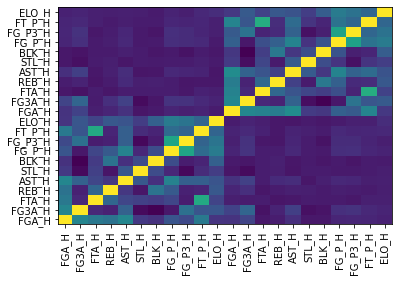

In [116]:
for col in predictdf_fixed.columns:
    predictdf_fixed[col] = predictdf_fixed[col].astype(float)

corr = predictdf_fixed.corr()

plt.pcolor(corr)
plt.yticks(np.arange(0.5, len(corr.index), 1), corr.index)
plt.xticks(np.arange(0.5, len(corr.columns), 1), corr.columns, rotation = 90)
plt.show()

In [163]:
## try again with pca
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

predict_fixed_standard = pd.DataFrame(StandardScaler().fit_transform(predictdf_fixed))
predict_fixed_standard.columns = predictdf_fixed.columns
pca = PCA(n_components= 17)
principalComponents = pca.fit_transform(predict_fixed_standard)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 
                          'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 
                         'PC17'])

predict_fixed_standard

,FGA_H,FG3A_H,FTA_H,REB_H,AST_H,STL_H,BLK_H,FG_P_H,FG_P3_H,FT_P_H,ELO_H,FGA_H,FG3A_H,FTA_H,REB_H,AST_H,STL_H,BLK_H,FG_P_H,FG_P3_H,FT_P_H,ELO_H
0,0.852173,0.503308,-0.240211,0.668992,0.203204,0.666398,-0.432157,0.921374,-0.243816,-0.691523,1.646282,0.142945,-0.183839,-1.164839,0.028546,0.504501,-1.236412,-0.623123,1.210344,1.150284,0.554150,1.685929
1,0.000646,0.069305,-0.860588,-0.185145,0.051073,-1.243493,-0.610356,1.470276,0.951049,1.089525,1.733250,0.902624,0.554791,-0.083577,0.838942,0.131449,0.523336,0.042651,0.487447,-0.628655,-0.744206,1.588836
2,0.836310,0.549512,-0.482963,0.925150,0.165703,0.019623,0.083917,0.682781,-0.466514,-1.236973,1.507134,0.188632,0.258001,-0.910495,-0.078492,0.225193,-0.900887,-0.858101,1.271617,0.997836,1.304132,1.818328
3,0.807066,0.708526,-0.714153,0.902037,-0.179774,-0.125344,0.053093,0.214376,-0.878522,-1.485174,1.385378,-0.001018,0.091688,-0.707421,0.404340,0.262877,-0.849327,-0.472437,0.786445,0.803418,0.826220,1.941901
4,-0.181842,-0.040086,-0.812324,0.272724,0.182741,-0.878089,-0.292757,0.718884,0.753059,0.993805,1.863703,1.040833,0.859921,-0.704190,1.132771,-0.127731,-0.282681,-0.137078,0.308531,-1.099484,-0.975427,1.465263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6677,-0.588843,-1.307967,0.903485,0.475209,-0.531019,-1.620153,-0.321449,-1.317216,-2.121270,0.725352,-1.136695,-0.792570,-2.544621,0.736158,1.326653,-0.083710,-0.234870,2.591741,1.019017,-0.636106,-0.163536,0.053002
6678,0.159009,-1.160223,-0.062365,0.356486,0.366294,0.485860,-0.216836,-1.257486,-2.200196,-0.632203,-0.954062,-0.321503,-1.097845,0.055322,-0.159026,0.088212,1.860191,1.602711,0.247176,-0.436428,-0.946505,-2.506721
6679,-0.604811,-0.442538,0.500975,-0.751925,-0.501482,-0.681670,-1.846726,-1.731179,-0.794852,-0.497679,-0.049595,-0.350515,-2.111342,2.509624,-0.576603,0.681607,-0.043582,0.238687,1.009674,-1.821412,1.758837,-1.421045
6680,-0.936176,-1.260912,0.574498,-0.273133,-0.947799,-0.630687,0.311947,0.216367,-0.091810,0.559174,0.072161,-1.088994,-1.999577,0.224463,-0.115975,-0.907210,-0.124822,-0.116369,-0.082810,0.733061,-0.139788,-1.800590


In [118]:
np.cumsum(pca.explained_variance_ratio_)

array([0.15510633, 0.2831913 , 0.35601593, 0.41994776, 0.48093763,
       0.54085645, 0.59461086, 0.64461936, 0.69211993, 0.73269112,
       0.77267728, 0.81015176, 0.83744279, 0.86424262, 0.89018539,
       0.91544559, 0.93255998])

In [141]:
model(predict_fixed_standard, results_fixed, splits = 10, classifier = 'log') ## NOTE: this is regularized

10it [00:00, 64.81it/s]


('Average Validation Error: {p_Accs: .2f}', 0.6565490096041102)

In [142]:
model(principalDf, results_fixed, splits = 10, classifier = 'log') ## NOTE: this is regularized

10it [00:00, 72.80it/s]


('Average Validation Error: {p_Accs: .2f}', 0.6550542412931983)

In [121]:
### want to (1) separate playoff and reg to get individual percentages (2) create model purely on upset games (3)
### go back and tweak things about current def and add desired features (4) see how it would model playoffs
### (5) fix hyperparams with grid search (6) get a function to predict each day and decide to bet or not 
### (7) automate updates and get it to send an email each day



In [143]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

lr = sklearn.linear_model.LogisticRegression()
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_search = GridSearchCV(LogisticRegression(solver='liblinear'), grid_values, cv=10, scoring="accuracy")
grid_search.fit(predict_fixed_standard, results_fixed)

print(grid_search.best_params_) 

{'C': 0.001, 'penalty': 'l2'}


In [147]:
### separate playoff and normal season

predict_playoffs = predictdf[NBAgamesC['PLAYOFF_H'] == 1]
results_playoffs = results[NBAgamesC['PLAYOFF_H'] == 1]

predict_playoffs = predict_playoffs[~predictdf.isnull().any(axis=1)]
results_playoffs = results_playoffs[~predictdf.isnull().any(axis=1)]

predict_playoffs_standard = pd.DataFrame(StandardScaler().fit_transform(predict_playoffs))

In [148]:
model(predict_playoffs_standard, results_playoffs, splits = 10, classifier = 'log') ## NOTE: this is regularized

10it [00:00, 115.42it/s]


('Average Validation Error: {p_Accs: .2f}', 0.6120408163265306)

In [145]:
overall_model = sklearn.linear_model.LogisticRegression()
overall_model.fit(predict_fixed_standard, results_fixed)

LogisticRegression()

In [151]:
sklearn.metrics.accuracy_score(results_playoffs, overall_model.predict(predict_playoffs_standard))

## accuracy for playoffs is lower, which means we need to account for playoff experience

0.6237424547283702

In [152]:
sklearn.metrics.r2_score(predict_fixed_standard, overall_model.predict(predict_fixed_standard))

-0.39909398974080657

In [157]:
pd.DataFrame.to_csv(predict_fixed_standard, '/Users/nickbachelder/Buckets Model/predict_fixed_standard')
pd.DataFrame.to_csv(results_fixed, '/Users/nickbachelder/Buckets Model/results_fixed')

In [158]:
NBAgamesC

,SEASON_ID_H,TEAM_ID_H,TEAM_ABBREVIATION_H,TEAM_NAME_H,GAME_ID_H,GAME_DATE_H,MATCHUP_H,WL_H,MIN_H,PTS_H,FGM_H,FGA_H,FG_PCT_H,FG3M_H,FG3A_H,FG3_PCT_H,FTM_H,FTA_H,FT_PCT_H,OREB_H,DREB_H,REB_H,AST_H,STL_H,BLK_H,TOV_H,PF_H,PLAYOFF_H,TEAM_ID_A,TEAM_ABBREVIATION_A,TEAM_NAME_A,MATCHUP_A,WL_A,MIN_A,PTS_A,FGM_A,FGA_A,FG_PCT_A,FG3M_A,FG3A_A,FG3_PCT_A,FTM_A,FTA_A,FT_PCT_A,OREB_A,DREB_A,REB_A,AST_A,STL_A,BLK_A,TOV_A,PF_A,PLAYOFF_A,WINMARGIN_H
0,2020,1610612749,MIL,Milwaukee Bucks,42000406,2021-07-20,MIL vs. PHX,1.0,240.0,105.0,37.0,82.0,0.451,6.0,27.0,0.222,25.0,29.0,0.862,11.0,42.0,53.0,20.0,10.0,6.0,18.0,17.0,1.0,1610612756,PHX,Phoenix Suns,PHX @ MIL,0.0,239.0,98.0,38.0,86.0,0.442,6.0,25.0,0.240,16.0,19.0,0.842,6.0,31.0,37.0,14.0,11.0,4.0,14.0,21.0,1.0,7.0
1,2020,1610612756,PHX,Phoenix Suns,42000405,2021-07-17,PHX vs. MIL,0.0,241.0,119.0,48.0,87.0,0.552,13.0,19.0,0.684,10.0,11.0,0.909,8.0,27.0,35.0,23.0,9.0,5.0,8.0,20.0,1.0,1610612749,MIL,Milwaukee Bucks,MIL @ PHX,1.0,240.0,123.0,50.0,87.0,0.575,14.0,28.0,0.500,9.0,17.0,0.529,11.0,26.0,37.0,26.0,7.0,1.0,11.0,17.0,1.0,-4.0
2,2020,1610612749,MIL,Milwaukee Bucks,42000404,2021-07-14,MIL vs. PHX,1.0,240.0,109.0,39.0,97.0,0.402,7.0,29.0,0.241,24.0,29.0,0.828,17.0,31.0,48.0,22.0,11.0,3.0,5.0,18.0,1.0,1610612756,PHX,Phoenix Suns,PHX @ MIL,0.0,240.0,103.0,40.0,78.0,0.513,7.0,23.0,0.304,16.0,19.0,0.842,5.0,35.0,40.0,18.0,3.0,9.0,17.0,24.0,1.0,6.0
3,2020,1610612749,MIL,Milwaukee Bucks,42000403,2021-07-11,MIL vs. PHX,1.0,240.0,120.0,43.0,90.0,0.478,14.0,36.0,0.389,20.0,26.0,0.769,13.0,34.0,47.0,28.0,8.0,2.0,9.0,18.0,1.0,1610612756,PHX,Phoenix Suns,PHX @ MIL,0.0,239.0,100.0,40.0,83.0,0.482,9.0,31.0,0.290,11.0,16.0,0.688,6.0,30.0,36.0,21.0,3.0,3.0,14.0,24.0,1.0,20.0
4,2020,1610612756,PHX,Phoenix Suns,42000402,2021-07-08,PHX vs. MIL,1.0,240.0,118.0,43.0,88.0,0.489,20.0,40.0,0.500,12.0,14.0,0.857,11.0,32.0,43.0,26.0,7.0,2.0,12.0,19.0,1.0,1610612749,MIL,Milwaukee Bucks,MIL @ PHX,0.0,240.0,108.0,42.0,93.0,0.452,9.0,31.0,0.290,15.0,23.0,0.652,18.0,28.0,46.0,21.0,8.0,7.0,9.0,17.0,1.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7987,2015,1610612766,CHA,Charlotte Hornets,1421500007,2015-07-05,CHA vs. MEM,0.0,200.0,75.0,28.0,63.0,0.444,11.0,31.0,0.355,8.0,12.0,0.667,6.0,27.0,33.0,16.0,7.0,4.0,17.0,27.0,0.0,1610612763,MEM,Memphis Grizzlies,MEM @ CHA,1.0,200.0,79.0,28.0,66.0,0.424,5.0,18.0,0.278,18.0,24.0,0.750,11.0,25.0,36.0,17.0,12.0,0.0,15.0,22.0,0.0,-4.0
7988,2015,1610612765,DET,Detroit Pistons,1421500006,2015-07-05,DET vs. LAC,1.0,199.0,77.0,29.0,72.0,0.403,4.0,16.0,0.250,15.0,21.0,0.714,13.0,30.0,43.0,16.0,10.0,1.0,13.0,20.0,0.0,1610612746,LAC,LA Clippers,LAC @ DET,0.0,200.0,69.0,28.0,68.0,0.412,1.0,14.0,0.071,12.0,21.0,0.571,10.0,30.0,40.0,13.0,8.0,3.0,18.0,25.0,0.0,8.0
7989,2015,1610612760,OKC,Oklahoma City Thunder,1421500004,2015-07-04,OKC vs. CHA,1.0,200.0,76.0,28.0,66.0,0.424,6.0,19.0,0.316,14.0,23.0,0.609,12.0,30.0,42.0,20.0,7.0,2.0,17.0,20.0,0.0,1610612766,CHA,Charlotte Hornets,CHA @ OKC,0.0,199.0,74.0,26.0,71.0,0.366,9.0,30.0,0.300,13.0,17.0,0.765,13.0,22.0,35.0,17.0,6.0,2.0,13.0,18.0,0.0,2.0
7990,2015,1610612754,IND,Indiana Pacers,1421500001,2015-07-04,IND vs. MIA,0.0,201.0,76.0,29.0,64.0,0.453,9.0,18.0,0.500,9.0,11.0,0.818,10.0,22.0,32.0,21.0,6.0,4.0,25.0,28.0,0.0,1610612748,MIA,Miami Heat,MIA @ IND,1.0,202.0,92.0,30.0,66.0,0.455,7.0,18.0,0.389,25.0,32.0,0.781,12.0,19.0,31.0,20.0,11.0,6.0,15.0,24.0,0.0,-16.0
